In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

In [2]:
!pip -q install pymorphy2 razdel gradio


In [3]:
import numpy as np
import re
from sklearn.model_selection import GroupShuffleSplit, train_test_split

In [4]:
df = pd.read_csv('movie_comments.csv')
df.head(10)

,text,label
0,Комедия получилась доброй и с душой. Смеха был...,no_spoiler
1,"Визуально фильм очень красивый, местами просто...",no_spoiler
2,Очень качественный звук и отличные спецэффекты...,no_spoiler
3,"То, что антагонист на самом деле отец главного...",spoiler
4,Герой жертвует собой ради спасения мира — эпич...,spoiler
5,"Финальный поворот, где героиня оказывается иск...",spoiler
6,"Визуально фильм очень красивый, местами просто...",no_spoiler
7,"Оказалось, что весь сюжет — это рассказ старик...",spoiler
8,Комедия получилась доброй и с душой. Смеха был...,no_spoiler
9,После просмотра остались только положительные ...,no_spoiler


In [5]:
# базовая чистка
def normalize(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('ё', 'е')
    return s

In [6]:
df['text_norm'] = df['text'].astype(str).apply(normalize)
df = df.dropna(subset=['text_norm', 'label'])

In [7]:
# убираем точные дубликаты по нормализованному тексту
df = df.drop_duplicates(subset=['text_norm', 'label']).reset_index(drop=True)

# группы по тексту (чтобы один и тот же комментарий не попал и в train, и в test)
df['group'] = df['text_norm'].factorize()[0]

X = df['text']           # сырой текст оставим для векторизаторов
y = df['label']
groups = df['group']

In [8]:
# делим на train+test с защитой от утечек
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_idx, test_idx = next(gss.split(X, y, groups))

In [9]:
X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

In [10]:
# из train_val делаем train/val
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.111, random_state=42)  # ≈ 0.1 от всего
tr_idx, val_idx = next(gss2.split(X_train_val, y_train_val, groups_train_val))

X_train, X_val = X_train_val.iloc[tr_idx], X_train_val.iloc[val_idx]
y_train, y_val = y_train_val.iloc[tr_idx], y_train_val.iloc[val_idx]

print(len(X_train), len(X_val), len(X_test))
print(y.value_counts(normalize=True))  # баланс классов

3941 493 493
label
no_spoiler    0.507205
spoiler       0.492795
Name: proportion, dtype: float64


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

pipe_bow = Pipeline([
    ('vec', CountVectorizer(stop_words=None)),  # можно подставить русские стоп-слова
    ('clf', MultinomialNB())
])

pipe_bow.fit(X_train, y_train)
pred_val = pipe_bow.predict(X_val)
print('=== BoW + NB (VAL) ===')
print(classification_report(y_val, pred_val, digits=4))


=== BoW + NB (VAL) ===
              precision    recall  f1-score   support

  no_spoiler     1.0000    1.0000    1.0000       253
     spoiler     1.0000    1.0000    1.0000       240

    accuracy                         1.0000       493
   macro avg     1.0000    1.0000    1.0000       493
weighted avg     1.0000    1.0000    1.0000       493



In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

pipe_tfidf_nb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ('clf', MultinomialNB())
])

# Подбор сглаживания NB
param_grid = {'clf__alpha': [0.1, 0.3, 0.7, 1.0]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe_tfidf_nb, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
print('Best CV f1_macro:', grid.best_score_)

best_tfidf_nb = grid.best_estimator_
pred_val = best_tfidf_nb.predict(X_val)
print('=== TF-IDF + NB (VAL) ===')
print(classification_report(y_val, pred_val, digits=4))


Best params: {'clf__alpha': 0.1}
Best CV f1_macro: 1.0
=== TF-IDF + NB (VAL) ===
              precision    recall  f1-score   support

  no_spoiler     1.0000    1.0000    1.0000       253
     spoiler     1.0000    1.0000    1.0000       240

    accuracy                         1.0000       493
   macro avg     1.0000    1.0000    1.0000       493
weighted avg     1.0000    1.0000    1.0000       493



In [13]:
import inspect
from collections import namedtuple

if not hasattr(inspect, "getargspec"):
    ArgSpec = namedtuple("ArgSpec", "args varargs keywords defaults")
    def getargspec(func):
        fs = inspect.getfullargspec(func)
        return ArgSpec(fs.args, fs.varargs, fs.varkw, fs.defaults)
    inspect.getargspec = getargspec

In [14]:
import pymorphy2
from razdel import tokenize

morph = pymorphy2.MorphAnalyzer()

# кэш ускоряет анализ
_cache = {}

def lemma_tokens(text: str):
    tokens = []
    for t in tokenize(text.lower()):
        w = t.text
        if not re.match(r'^[а-яё-]+$', w):  # только русские слова и дефисы
            continue
        if w in _cache:
            tokens.append(_cache[w])
            continue
        normal = morph.parse(w)[0].normal_form
        _cache[w] = normal
        tokens.append(normal)
    return tokens

pipe_lemma_tfidf_nb = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer=lemma_tokens, ngram_range=(1,2), min_df=2, max_df=0.95)),
    ('clf', MultinomialNB(alpha=grid.best_params_['clf__alpha']))  # можно снова подобрать
])

pipe_lemma_tfidf_nb.fit(X_train, y_train)
pred_val = pipe_lemma_tfidf_nb.predict(X_val)
print('=== Lemma TF-IDF + NB (VAL) ===')
print(classification_report(y_val, pred_val, digits=4))


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


=== Lemma TF-IDF + NB (VAL) ===
              precision    recall  f1-score   support

  no_spoiler     1.0000    1.0000    1.0000       253
     spoiler     1.0000    1.0000    1.0000       240

    accuracy                         1.0000       493
   macro avg     1.0000    1.0000    1.0000       493
weighted avg     1.0000    1.0000    1.0000       493



In [15]:
from sklearn.svm import LinearSVC

pipe_char_svc = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2, max_df=0.9)),
    ('clf', LinearSVC())
])

pipe_char_svc.fit(X_train, y_train)
pred_val = pipe_char_svc.predict(X_val)
print('=== Char 3-5 + LinearSVC (VAL) ===')
print(classification_report(y_val, pred_val, digits=4))


=== Char 3-5 + LinearSVC (VAL) ===
              precision    recall  f1-score   support

  no_spoiler     1.0000    1.0000    1.0000       253
     spoiler     1.0000    1.0000    1.0000       240

    accuracy                         1.0000       493
   macro avg     1.0000    1.0000    1.0000       493
weighted avg     1.0000    1.0000    1.0000       493



/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


=== FINAL (TEST) ===
              precision    recall  f1-score   support

  no_spoiler     1.0000    1.0000    1.0000       240
     spoiler     1.0000    1.0000    1.0000       253

    accuracy                         1.0000       493
   macro avg     1.0000    1.0000    1.0000       493
weighted avg     1.0000    1.0000    1.0000       493



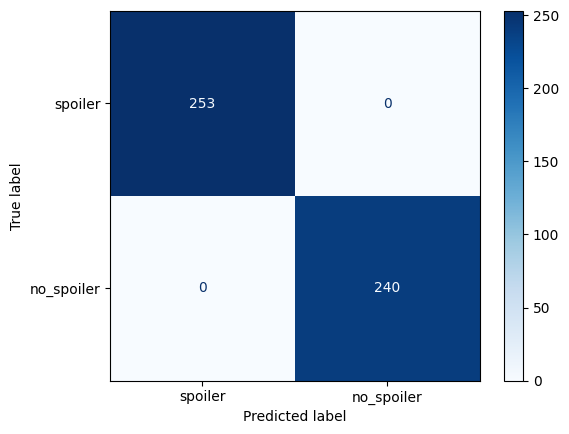

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_model = pipe_lemma_tfidf_nb  # например

best_model.fit(pd.concat([X_train, X_val]),
               pd.concat([y_train, y_val]))

pred_test = best_model.predict(X_test)
print('=== FINAL (TEST) ===')
print(classification_report(y_test, pred_test, digits=4))

cm = confusion_matrix(y_test, pred_test, labels=['spoiler','no_spoiler'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['spoiler','no_spoiler'])
disp.plot(cmap='Blues'); plt.show()


In [17]:
import joblib

# из Pipeline можно достать векторизатор и модель
vec = best_model.named_steps['tfidf']
clf = best_model.named_steps['clf']

joblib.dump(vec, 'vec.pkl')
joblib.dump(clf, 'spoiler_detector.pkl')


['spoiler_detector.pkl']

In [18]:
import gradio as gr

def predict_spoiler(text):
    label = best_model.predict([text])[0]
    proba = None
    try:
        # NB умеет predict_proba, SVC — нет
        proba = best_model.predict_proba([text])[0].max().round(3)
    except Exception:
        pass
    return f'{label} (confidence: {proba})' if proba is not None else label

demo = gr.Interface(fn=predict_spoiler,
                    inputs=gr.Textbox(lines=3, placeholder="Введите комментарий..."),
                    outputs="text",
                    title="Spoiler Detector (ru)",
                    description="NLP baseline: TF-IDF + NB / лемматизация")
demo.launch(debug=False)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c54b8606cd8194f4d7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
